## 🛠️ Extension: Fine-Tuning Longformer on MedNLI (Long-Context Ablation) - with Mixed Precision for Faster Training


In [1]:
#───────────────────────────────────────────────────────────────────────────────
# 1. Imports
#───────────────────────────────────────────────────────────────────────────────
import torch
from torch.cuda.amp import GradScaler, autocast
from transformers import LongformerForSequenceClassification, LongformerTokenizer, get_linear_schedule_with_warmup
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os
import random
from google.colab import drive

#───────────────────────────────────────────────────────────────────────────────
# 2. Configuration
#───────────────────────────────────────────────────────────────────────────────
MODEL_NAME = "allenai/longformer-base-4096"
TASK = "mednli"
DATA_DIR = "/content/drive/MyDrive/DL4H-Project/data/mednli/full"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
OUTPUT_DIR = "/content/drive/MyDrive/DL4H-Project/ablation_outputs"

drive.mount('/content/drive')

# Create ablation output directory
if not os.path.exists(OUTPUT_DIR):
    print(f"Creating output directory: {OUTPUT_DIR}")
    os.makedirs(OUTPUT_DIR)
else:
    print(f"Output directory already exists: {OUTPUT_DIR}")


# Input lengths to test
# INPUT_LENGTHS = [128, 256, 512]
INPUT_LENGTHS = [512, 1024, 2048]
# Hyperparameters
BATCH_SIZE = 4
LEARNING_RATE = 2e-5
EPOCHS = 2
SEED = 42

random.seed(SEED)
torch.manual_seed(SEED)
np.random.seed(SEED)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Output directory already exists: /content/drive/MyDrive/DL4H-Project/ablation_outputs


In [2]:
#───────────────────────────────────────────────────────────────────────────────
# 3. MedNLILongDataset Class
#───────────────────────────────────────────────────────────────────────────────

class MedNLILongDataset(Dataset):
    def __init__(self, file_path, tokenizer, max_length):
        self.examples = []
        with open(file_path, 'r') as f:
            for line in f:
                ex = json.loads(line)
                self.examples.append(ex)
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.label_map = {"entailment":0, "neutral":1, "contradiction":2}

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, idx):
        ex = self.examples[idx]
        premise = ex['sentence1']
        hypothesis = ex['sentence2']
        label = self.label_map[ex['gold_label']]

        encoding = self.tokenizer(
            premise,
            hypothesis,
            padding='max_length',
            truncation=True,
            max_length=self.max_length,
            return_tensors='pt'
        )

        input_ids = encoding['input_ids'].squeeze()
        attention_mask = encoding['attention_mask'].squeeze()
        global_attention_mask = torch.zeros_like(attention_mask)
        global_attention_mask[0] = 1

        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'global_attention_mask': global_attention_mask,
            'labels': torch.tensor(label, dtype=torch.long)
        }



In [3]:
#───────────────────────────────────────────────────────────────────────────────
# 4. Training and Evaluation Functions
#───────────────────────────────────────────────────────────────────────────────

def train_one_epoch(model, optimizer, loader, device, scaler):
    model.train()
    total_loss = 0
    for batch in loader:
        optimizer.zero_grad()
        batch = {k: v.to(device) for k, v in batch.items()}
        with autocast():
            outputs = model(
                input_ids=batch['input_ids'],
                attention_mask=batch['attention_mask'],
                global_attention_mask=batch['global_attention_mask'],
                labels=batch['labels']
            )
            loss = outputs.loss
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        total_loss += loss.item()
    return total_loss / len(loader)

def evaluate(model, loader, device):
    model.eval()
    preds, labels = [], []
    with torch.no_grad():
        for batch in loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(
                input_ids=batch['input_ids'],
                attention_mask=batch['attention_mask'],
                global_attention_mask=batch['global_attention_mask'],
                labels=batch['labels']
            )
            logits = outputs.logits
            preds.append(logits.argmax(dim=-1).cpu().numpy())
            labels.append(batch['labels'].cpu().numpy())
    preds = np.concatenate(preds)
    labels = np.concatenate(labels)
    acc = (preds == labels).mean()
    return acc

In [4]:
#───────────────────────────────────────────────────────────────────────────────
# 5. Run Ablation for Different Input Lengths
#───────────────────────────────────────────────────────────────────────────────

results = []

for input_len in INPUT_LENGTHS:
    print(f"\n🧪 Running Longformer for max_input_length={input_len}")

    tokenizer = LongformerTokenizer.from_pretrained(MODEL_NAME)
    model = LongformerForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=3).to(DEVICE)
    model.gradient_checkpointing_enable()
    model.config.use_cache = False

    train_dataset = MedNLILongDataset(os.path.join(DATA_DIR, "train.jsonl"), tokenizer, input_len)
    val_dataset   = MedNLILongDataset(os.path.join(DATA_DIR, "dev.jsonl"), tokenizer, input_len)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE)

    optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
    scaler = GradScaler()

    for epoch in range(EPOCHS):
        train_loss = train_one_epoch(model, optimizer, train_loader, DEVICE, scaler)
        print(f"Epoch {epoch+1} - Train Loss: {train_loss:.4f}")

    val_acc = evaluate(model, val_loader, DEVICE)
    print(f"Validation Accuracy at max_input_length={input_len}: {val_acc:.4f}")

    results.append({"input_length": input_len, "val_accuracy": val_acc})



🧪 Running Longformer for max_input_length=512


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of LongformerForSequenceClassification were not initialized from the model checkpoint at allenai/longformer-base-4096 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-4-41430834145d>:22: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. 

Epoch 1 - Train Loss: 0.8014
Epoch 2 - Train Loss: 0.5793
Validation Accuracy at max_input_length=512: 0.7849

🧪 Running Longformer for max_input_length=1024


Some weights of LongformerForSequenceClassification were not initialized from the model checkpoint at allenai/longformer-base-4096 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1 - Train Loss: 1.0799
Epoch 2 - Train Loss: 1.1019
Validation Accuracy at max_input_length=1024: 0.3333

🧪 Running Longformer for max_input_length=2048


Some weights of LongformerForSequenceClassification were not initialized from the model checkpoint at allenai/longformer-base-4096 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1 - Train Loss: 1.1034
Epoch 2 - Train Loss: 1.1010
Validation Accuracy at max_input_length=2048: 0.3333


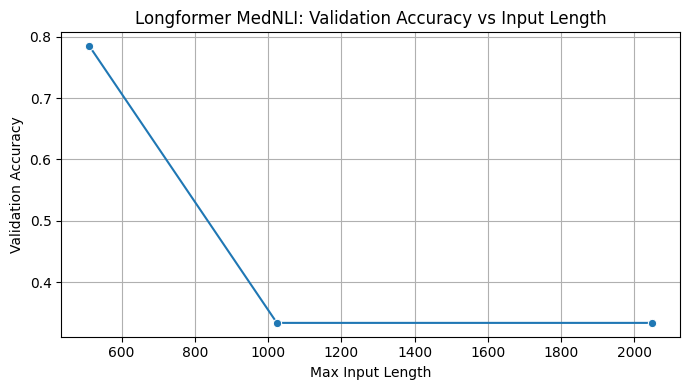

✅ Longformer Ablation experiment completed!


<Figure size 640x480 with 0 Axes>

In [5]:
#───────────────────────────────────────────────────────────────────────────────
# 6. Plot the Results
#───────────────────────────────────────────────────────────────────────────────

results_df = pd.DataFrame(results)

plt.figure(figsize=(7,4))
sns.lineplot(data=results_df, x="input_length", y="val_accuracy", marker="o")
plt.title("Longformer MedNLI: Validation Accuracy vs Input Length")
plt.xlabel("Max Input Length")
plt.ylabel("Validation Accuracy")
plt.grid(True)
plt.tight_layout()
plt.show()
# save the plot
plt.savefig(os.path.join(OUTPUT_DIR, "longformer_mednli_input_length_ablation.png"))

# Save Results
results_df.to_csv(os.path.join(OUTPUT_DIR, "longformer_mednli_input_length_ablation.csv"), index=False)
print("✅ Longformer Ablation experiment completed!")

